# So you have a bad registration....

Originally, this class was going to be all about registration, starting with the bad registration example from last week. The answer to solving this problem lay in the choices made before registration was even performed, so although we'll start with registration, we'll mostly talk about bias correction, with one new python concept and a bit more matplotlib for good measure. First, the results from last week that we are going to investigate

In [1]:
# setting up directories as usual
import pathlib
mypirg = 'lcni'

In [2]:
classdir = pathlib.Path('/projects/lcni/jolinda/shared/TalapasClass')

In [3]:
old_output = pathlib.Path.home() / mypirg /'class9out'

In [4]:
badsubject = 'sub-04_ses-test'

In [5]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [6]:
t1 = old_output / (badsubject + '.anat') / 'T1_to_MNI_lin.nii.gz'

I've been cutting and pasting some code for viewing nifti files a lot. That's a sign that I need to define a function! This eventually snowballed into the "niftiview.py" module, but since that's not quite ready for consumption we'll define a function here. But first...

# a few words on matplotlib.pyplot
If, like me, you jumped into using matplotlib without actually reading any documentation first, you may have been a bit confused by some of the terminology. This is the page I wish I had read sooner: https://matplotlib.org/tutorials/introductory/pyplot.html. Here's a quick guide.  
  
There are two main ways of doing anything with pyplot: the pyplot api and the object-oriented api. Here's an example of each: 

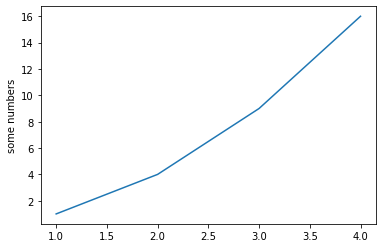

In [7]:
# api way
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])
plt.ylabel('some numbers')
plt.show()

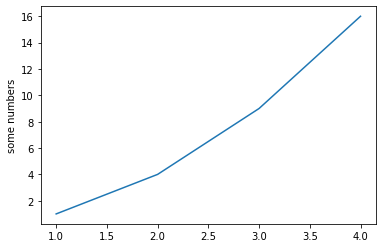

In [8]:
# object oriented way
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([1, 2, 3, 4], [1, 4, 9, 16])
ax.set_ylabel('some numbers')
plt.show()

You'll see people (including me) using one, the other, or both mixed together. The important (and not necessarily obvious) points are: 
1. an 'axes' object is the box that holds the stuff you're plotting. It includes individual 'axis' objects (which are not the same thing!), lines, text, legends, etc.
2. the 'figure' is everything you are plotting, including multiple subplots
3. 'subplots' and 'add_subplots' are commands; they return 'axes'. Axes are objects, subplots are not.
4. plt.plot() and other commands are shorthand for 'run this command on the current axes object'

Let's define our new function now. It takes a list of 3 axes objects as an argument. This way we can add more niftifiles to our figure as overlays (we did this last week with the brain masks). I've added a 'transparent' parameter to use for overlays instead of the alpha value we used before. This will result in an opaque overlay except where voxel values == 0. The 'alpha' approach still works fine if you like it better, just pass it as one of the kwargs.

In [38]:
def orthoview(niftifilename, axes, zslice = None, transparent = False, **kwargs):
    
    niftifile = nib.load(str(niftifilename))

    xslice = niftifile.shape[0]//2
    yslice = niftifile.shape[1]//2
    
    # default is 'middle' slice
    if not zslice:
        zslice = niftifile.shape[2]//2

    xaspect = niftifile.header.get_zooms()[2]/niftifile.header.get_zooms()[1]
    yaspect = niftifile.header.get_zooms()[2]/niftifile.header.get_zooms()[0]
    zaspect = niftifile.header.get_zooms()[1]/niftifile.header.get_zooms()[0]
    
    if transparent:
        data = np.ma.masked_where(niftifile.get_fdata() == 0, niftifile.get_fdata())
    else:
        data = niftifile.get_fdata()


    axes[0].imshow(np.rot90(data[xslice,:,:]), aspect = xaspect, **kwargs)
    axes[1].imshow(np.rot90(data[:,yslice,:]), aspect = yaspect, **kwargs)
    axes[2].imshow(np.rot90(data[:,:,zslice]), aspect = zaspect, **kwargs)

    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')

New python concept time!
# **kwargs
`**kwargs` means 'key word arguments': anything you specify with key = value when calling a function. By using it here, we can pass along any of the many arguments that are accepted by the imshow command without having to explicitly write them out. This is good because otherwise we'd have to write something like this (abreviated for clarity):
```
def orthoview(niftifile, axes, cmap = None, alpha = None, vmax = None):
    ...
    imshow(niftifile.dataobj, aspect = aspect, cmap = cmap, alpha = alpha, vmax = vmax)
```
Which is more verbose, and we'd have to rewrite our function whenever we realized we needed to include another parameter. 

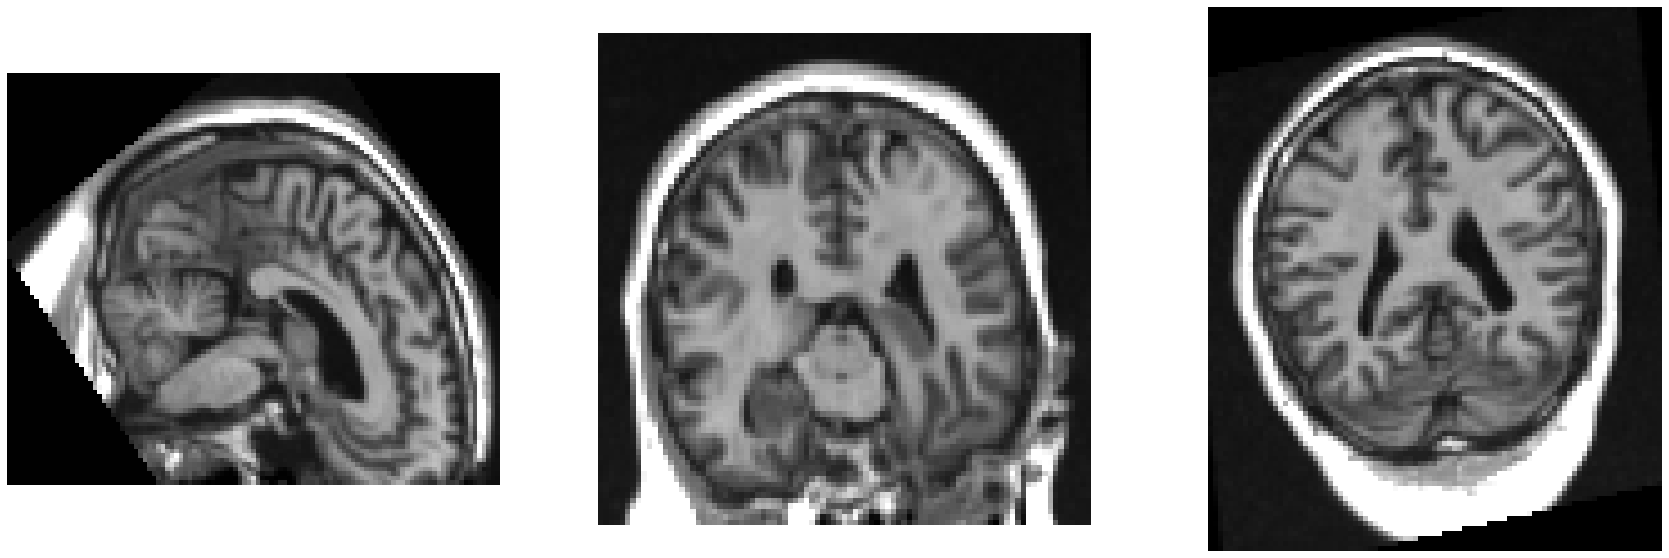

In [30]:
# the fig, ax declarations and plt.show() call are outside the function.
# This will let us use the same function for overlays later.
fig, ax = plt.subplots(1, 3, figsize=(30,10))
orthoview(t1, ax, vmax = 1000, cmap = 'gray')
plt.show()

In [31]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaad8b2ab70>,
      dtype=object)

Clearly something is very wrong! When a command produces unexpected output we need to ask ourselves some questions:
* what exactly does this command do, and do we understand it?
* what parameters and options exist, and are the ones we chose appropriate for our data?
* is there something about my data that's different from the data this tool was developed for?  
  
Of course we should really ask ourselves these questions BEFORE running a command, or even when it does produce the expected output. How to find out what a command does and it's parameters? Resource one is the command itself -- running it with no input should give us an error message.

In [11]:
%%bash --no-raise-error
module load fsl/6.0.1
fsl_anat

Usage: fsl_anat [options] -i <structural image>
       fsl_anat [options] -d <existing anat directory>
 
Arguments (You may specify one or more of):
  -i <strucural image>         filename of input image (for one image only)
  -d <anat dir>                directory name for existing .anat directory where this script will be run in place
  -o <output directory>        basename of directory for output (default is input image basename followed by .anat)
  --clobber                    if .anat directory exist (as specified by -o or default from -i) then delete it and make a new one
  --strongbias                 used for images with very strong bias fields
  --weakbias                   used for images with smoother, more typical, bias fields (default setting)
  --noreorient                 turn off step that does reorientation 2 standard (fslreorient2std)
  --nocrop                     turn off step that does automated cropping (robustfov)
  --nobias                     turn off steps tha

Resource two is the web site for the software: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/fsl_anat. From that site:

This tool provides a general pipeline for processing anatomical images (e.g. T1-weighted scans). Most of the pipeline involves standard use of FSL tools, but the bias-field correction has been substantially improved, especially for strong bias-fields typical of multi-coil arrays and high-field scanners.

The stages in the pipeline (in order) are:
* reorient the images to the standard (MNI) orientation [fslreorient2std]
* automatically crop the image [robustfov]
* bias-field correction (RF/B1-inhomogeneity-correction) [FAST]
* registration to standard space (linear and non-linear) [FLIRT and FNIRT]
* brain-extraction [FNIRT-based or BET]
* tissue-type segmentation [FAST]
* subcortical structure segmentation [FIRST]


The fsl site also includes the above usage message, but it does not match the 6.0.1 version and even contradicts it, stating the default is strong bias. Probably the web site is for a previous version and they neglected to update it, but it does mean we aren't sure of the default bias setting. Taking the pipeline step by step:

* fslreorient2std -- unnecessary with this data, but it won't hurt anything, normally a good idea
* robustfov -- a good idea
* bias-field correction -- do we need this, and is the default weak or strong?
* registration -- where things went wrong. Both FLIRT and FNIRT have various options which can't be changed in a call to fsl_anat. 
* brain-extraction -- we tried BET before and it didn't work well for this data, but the FNIRT based method used by fsl_anat worked great! 
* segmentation -- not our problem today  
  
We can also get some clues about how it works by looking at the log file in the output directory. Most FSL tools produce log files and they can be quite helpful.

In [12]:
with open (old_output / (badsubject + '.anat') / 'log.txt') as f:
    print(f.read())

Script invoked from directory = /gpfs/home/jolinda/notebooks/zoomclass
Output directory = /home/jolinda/lcni/class9out/sub-04_ses-test.anat
Input image is /projects/lcni/jolinda/shared/TalapasClass/ds000114/sub-04/ses-test/anat/sub-04_ses-test_T1w
 
/packages/fsl/6.0.1/fsl/bin/fslmaths T1 T1_orig
/packages/fsl/6.0.1/fsl/bin/fslreorient2std T1
/packages/fsl/6.0.1/fsl/bin/convert_xfm -omat T1_std2orig.mat -inverse T1_orig2std.mat
/packages/fsl/6.0.1/fsl/bin/fslreorient2std T1 T1
/packages/fsl/6.0.1/fsl/bin/immv T1 T1_fullfov
/packages/fsl/6.0.1/fsl/bin/robustfov -i T1_fullfov -r T1 -m T1_roi2nonroi.mat
/packages/fsl/6.0.1/fsl/bin/convert_xfm -omat T1_nonroi2roi.mat -inverse T1_roi2nonroi.mat
/packages/fsl/6.0.1/fsl/bin/convert_xfm -omat T1_orig2roi.mat -concat T1_nonroi2roi.mat T1_orig2std.mat
/packages/fsl/6.0.1/fsl/bin/convert_xfm -omat T1_roi2orig.mat -inverse T1_orig2roi.mat
/packages/fsl/6.0.1/fsl/bin/bet T1 T1_initfast2_brain -m -f 0.1
/packages/fsl/6.0.1/fsl/bin/fslmaths T1_initfa

This is pretty typical for an FSL log file. First it copies the input file to a file with a generic name, runs a bunch of commands, then deletes intermediate files (that's the imrm command at the end). It's ALMOST possible to just run this as a script as is, but not quite. An example is in lines 2 & 3: the actual commands in the original fsl_anat script are:  
```
    run $FSLDIR/bin/fslreorient2std ${T1} > ${T1}_orig2std.mat
    run $FSLDIR/bin/convert_xfm -omat ${T1}_std2orig.mat -inverse ${T1}_orig2std.mat
```
but in the output file we only see:
```
/packages/fsl/6.0.1/fsl/bin/fslreorient2std T1
/packages/fsl/6.0.1/fsl/bin/convert_xfm -omat T1_std2orig.mat -inverse T1_orig2std.mat
```
because the `> ${T1}_orig2std.mat` part, which writes the output of fslreorient2std to a file, doesn't get logged.

The first part of the process that raises questions is the bias correction. So what is 'bias' and why do we need to correct it? It's unevenness in the image intensity that arises from the RF hardware: either non-uniformity in the transmit RF field, or non-uniformity in the receive coil sensitivity. The first source is unlikely at 3T on objects the size of human brains, but it does come into play at 7T and higher. The second source is what we're dealing with at 3T, especially with high-element count receive coil arrays, which have higher sensitivity nearer to the coil elements (at the brain surface) and less sensitivity further away (deep in the brain).  

The brain image on the left is an example of an image with no correction applied -- it's noticably darker in the center. The other two show different types of bias correction. These brightness gradients can cause problems with any intensity-based processing or segmentation.

![brains](bias.jpg)  
  
from Stamm A, Singh J, Afacan O, Warfield SK. Analytic quantification of bias and variance of coil sensitivity profile estimators for improved image reconstruction in MRI. Med Image Comput Comput Assist Interv. 2015;9350:684‐691. doi:10.1007/978-3-319-24571-3_82

One way (besides just looking at it) to judge intensity bias is to "draw" a line through the image and look at the values. We can do that with pyplot just by specifying our indices. I wrote another special function to do this.

In [13]:
def profile(filename, zslice = None, **kwargs):
    niftifile = nib.load(str(filename))
    if not zslice:
        zslice = niftifile.shape[2]//2
    hline = niftifile.shape[1] / 2
    zaspect = niftifile.header.get_zooms()[1]/niftifile.header.get_zooms()[0]
    fig, ax = plt.subplots(1, 2, figsize=(20,5), gridspec_kw={'width_ratios': [1, 3]})
    ax[0].imshow(np.rot90(niftifile.dataobj[:,:,zslice]), aspect = zaspect, **kwargs)
    ax[0].axis('off')
    ax[0].axhline(y=hline)
    ax[1].plot(niftifile.dataobj[:,hline,zslice])
    plt.show()

On the Skyra, there are NINE mutually exclusive ways of dealing with bias:
* turn everything off and ignore it
* prescan normalize: normal, moderate, or broad
* postscan normalization
* b1 bias: weak, medium, or strong
  
The default for an mprage is prescan normalize: normal. Prescan normalization works by first taking a low resolution image with the head coil as the receive coil and another with the body coil as the receive coil. The body coil produces a much more homogeneous image, so the difference between the two can be used to correct subsequent ones. This correction is performed on the fully complex data, so it can't be undone once that data disappears.

In [14]:
bias_examples = classdir / 'bids_example' / 'sub-biasdemo'

/projects/lcni/jolinda/shared/TalapasClass/bids_example/sub-biasdemo/anat/sub-biasdemo_run-02_pnorm.nii.gz


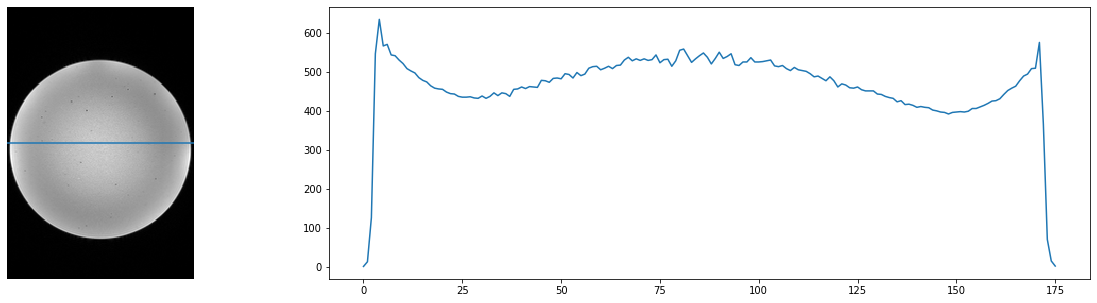

/projects/lcni/jolinda/shared/TalapasClass/bids_example/sub-biasdemo/anat/sub-biasdemo_run-03_pmod.nii.gz


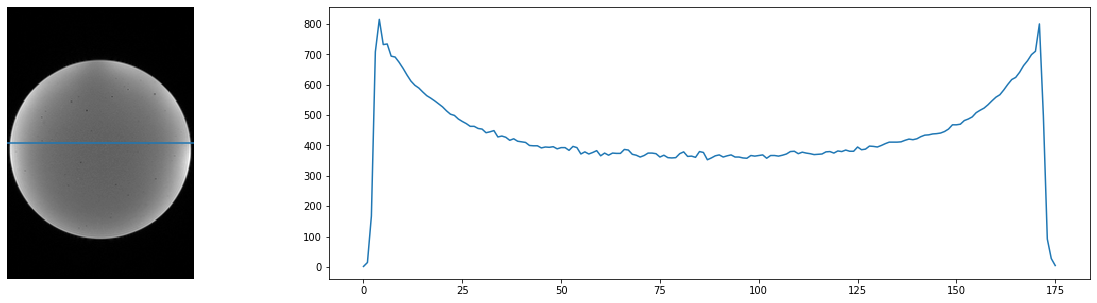

/projects/lcni/jolinda/shared/TalapasClass/bids_example/sub-biasdemo/anat/sub-biasdemo_run-04_pbroad.nii.gz


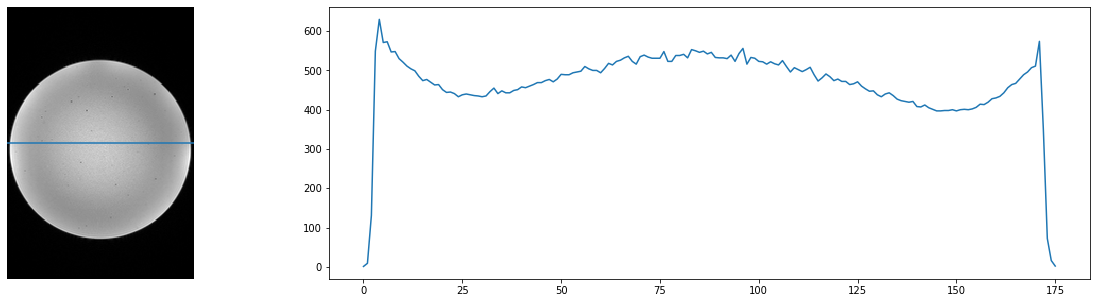

/projects/lcni/jolinda/shared/TalapasClass/bids_example/sub-biasdemo/anat/sub-biasdemo_run-05_none.nii.gz


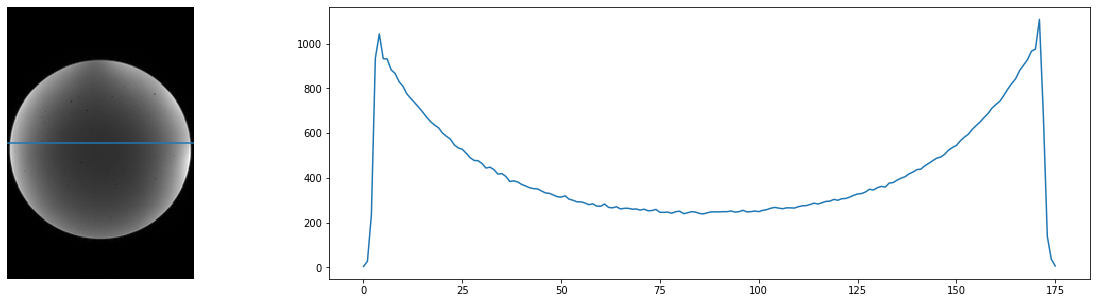

/projects/lcni/jolinda/shared/TalapasClass/bids_example/sub-biasdemo/anat/sub-biasdemo_run-06_post.nii.gz


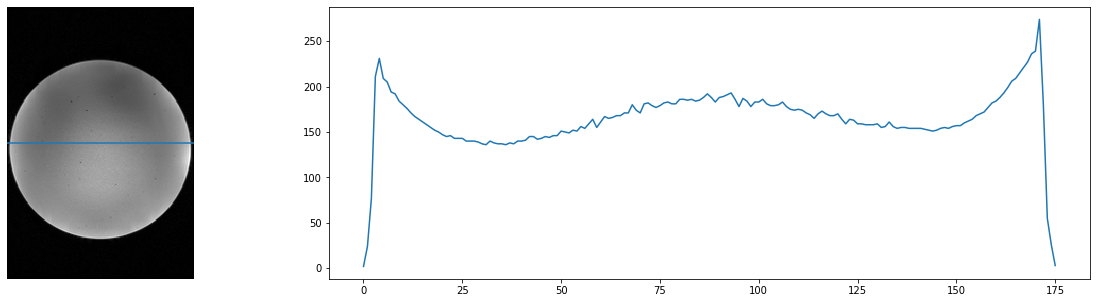

/projects/lcni/jolinda/shared/TalapasClass/bids_example/sub-biasdemo/anat/sub-biasdemo_run-07_b1weak.nii.gz


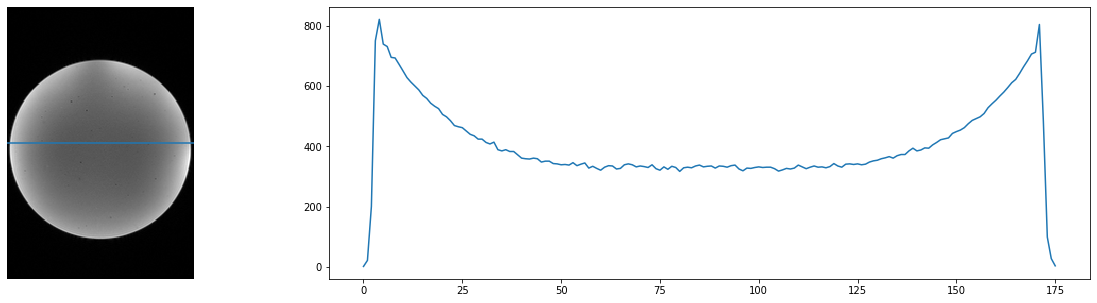

/projects/lcni/jolinda/shared/TalapasClass/bids_example/sub-biasdemo/anat/sub-biasdemo_run-08_b1med.nii.gz


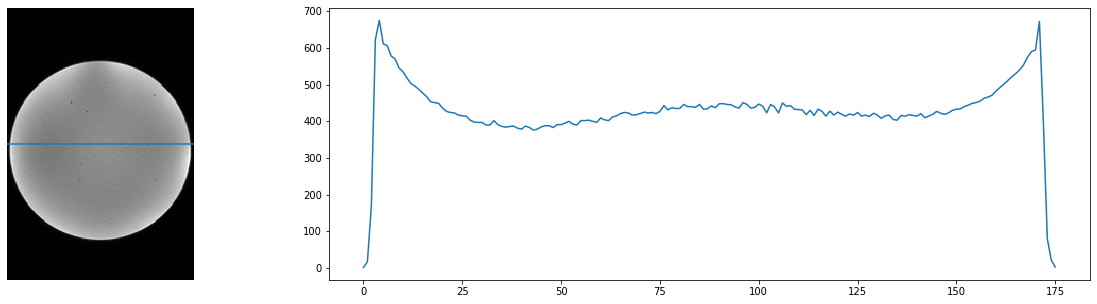

/projects/lcni/jolinda/shared/TalapasClass/bids_example/sub-biasdemo/anat/sub-biasdemo_run-09_b1strong.nii.gz


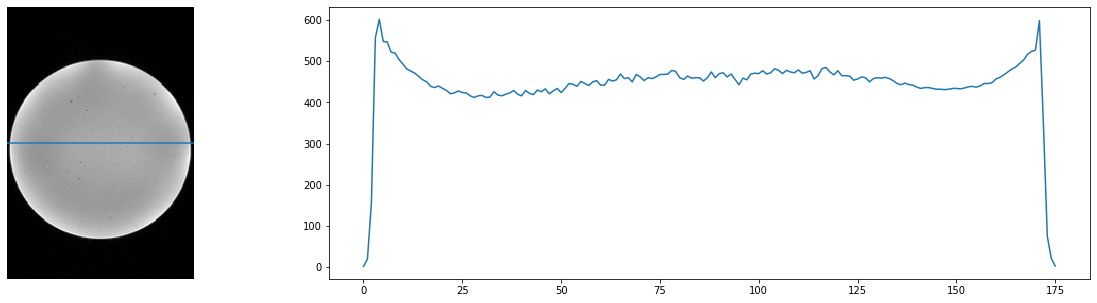

In [20]:
for mprage in sorted(bias_examples.rglob('*.nii.gz')):
    print(mprage)
    profile(mprage, cmap = 'gray')

That's a completely uniform phantom, so the 'true' profile should be completely flat. As you can see, none of the options get there, which is why post-processing bias correction exists.

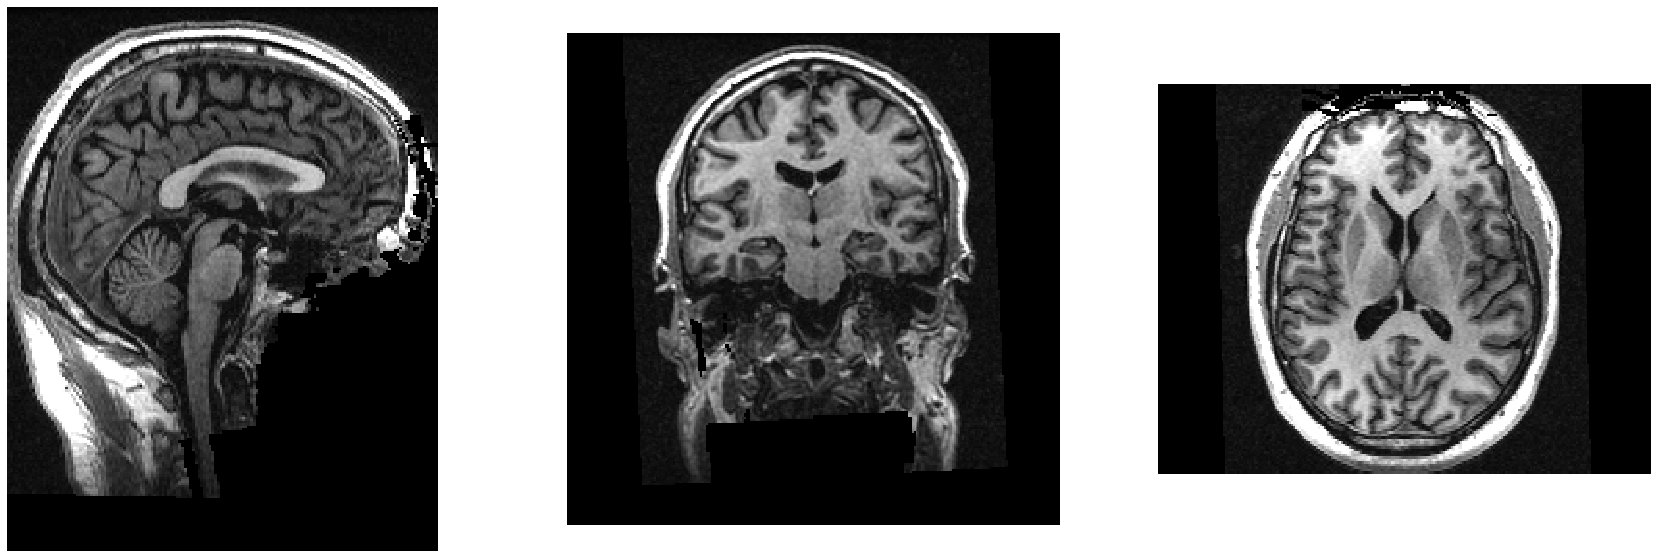

In [18]:
# let's look at the original T1 image and evaluate it for homogeneity
original_T1 = old_output / (badsubject + '.anat') / 'T1_orig.nii.gz'
fig, ax = plt.subplots(1, 3, figsize=(30,10))
orthoview(original_T1, ax, vmax = 1000, cmap = 'gray', zslice = 170)
plt.show()

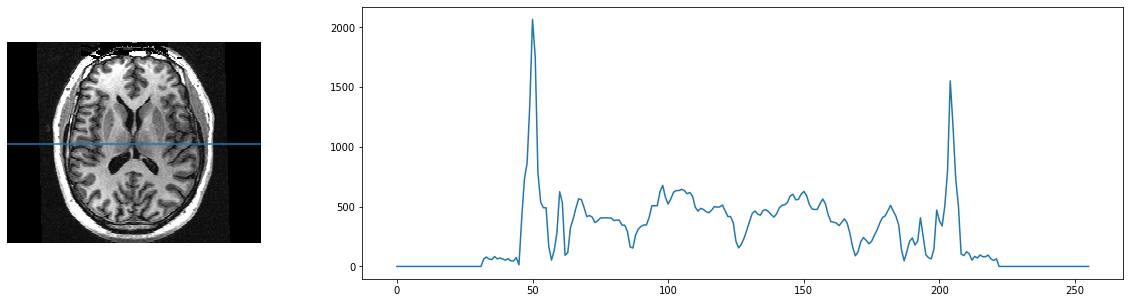

In [71]:
profile(original_T1, zslice = 170, cmap = 'gray', vmax = 1000)

How does this compare to other 'typical' T1w images? I've put another example dataset in the class folder:

In [25]:
list(classdir.glob('ds*'))

[PosixPath('/projects/lcni/jolinda/shared/TalapasClass/ds000114'),
 PosixPath('/projects/lcni/jolinda/shared/TalapasClass/ds001728')]

In [41]:
T1_otherstudy = next((classdir / 'ds001728').rglob('*T1w.nii.gz'))

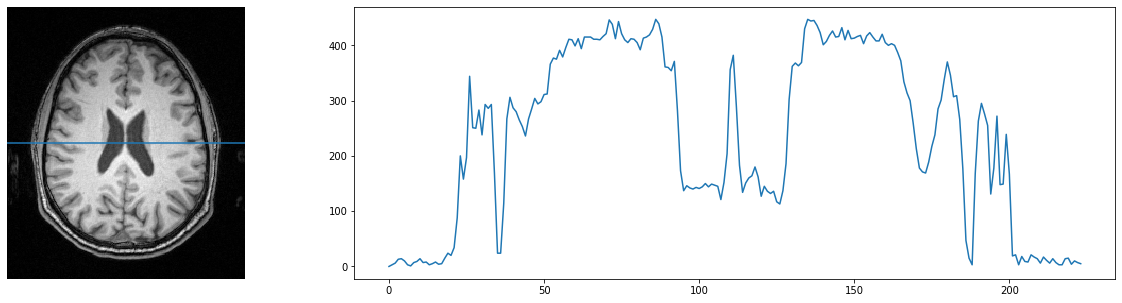

In [42]:
profile(T1_otherstudy, cmap = 'gray')

What jumps out? The scalp is MUCH BRIGHTER in our "problem" dataset! This is likely to be the cause of all of our trouble: the data was acquired with inadequate fat suppression. So what is the effect of bias correction on this particular data set? I ran fsl_anat with three options: --nobias, --weakbias, and --strongbias. Here are the results.

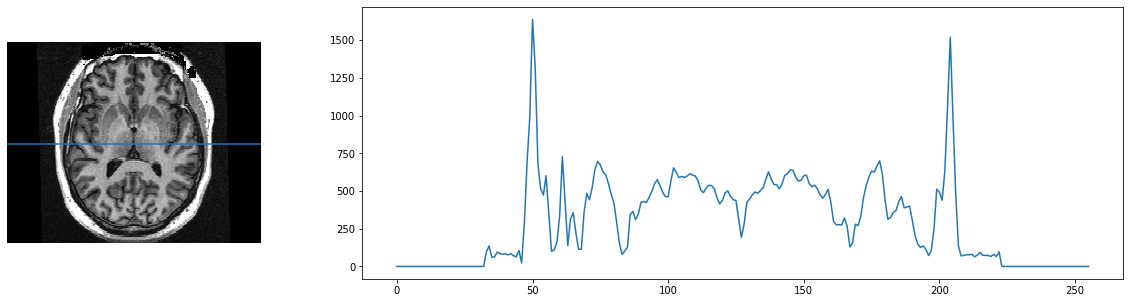

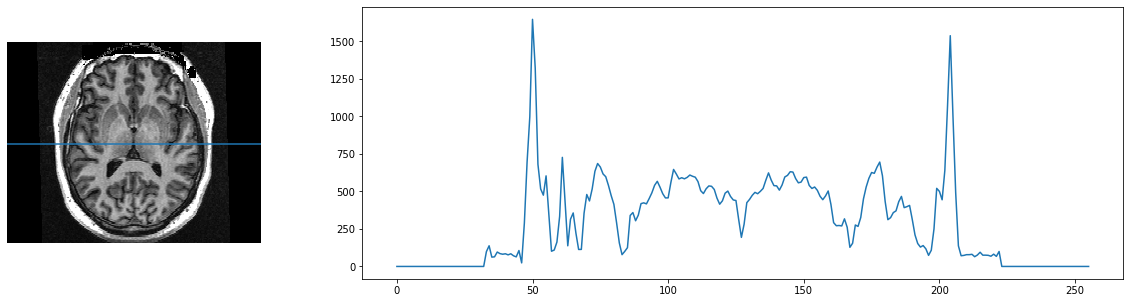

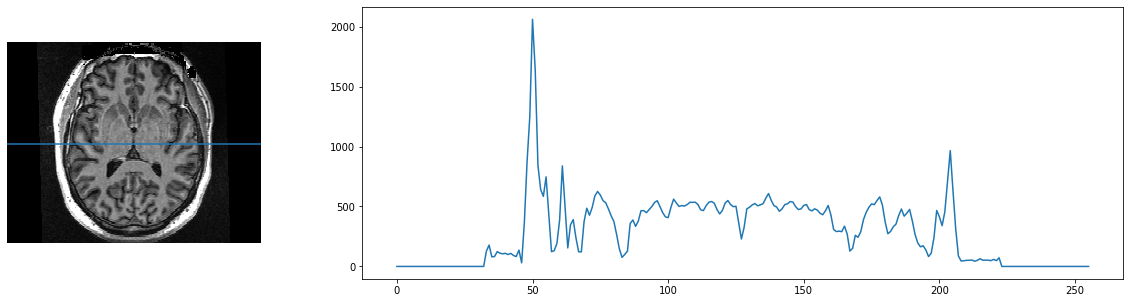

In [75]:
for biastype in ['nobias', 'weakbias', 'strongbias']:
    filename = classdir / 'biascompare'/ 'ds000114'/ (biastype + '.anat') / 'T1_biascorr.nii.gz'
    profile(filename, cmap = 'gray', vmax = 1000)

What do we see? I can't tell a difference between nobias and weakbias, but strongbias shows a definite loss of contrast, and it's exaggerated the relative brightness of the fat. What effect does it have on our registration & brain extraction?

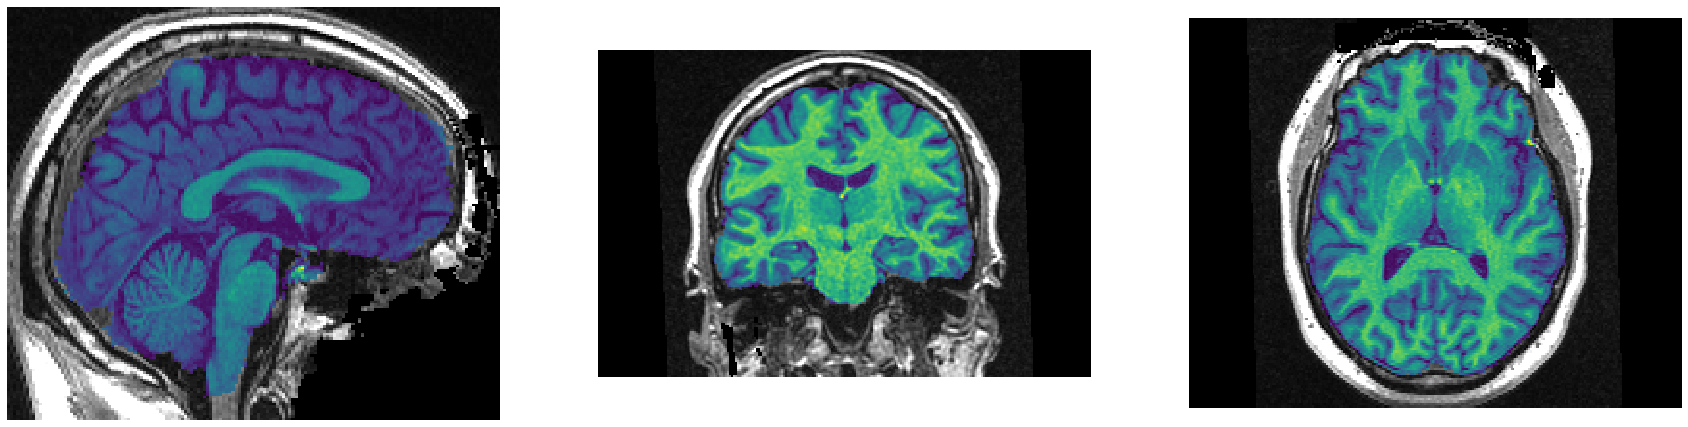

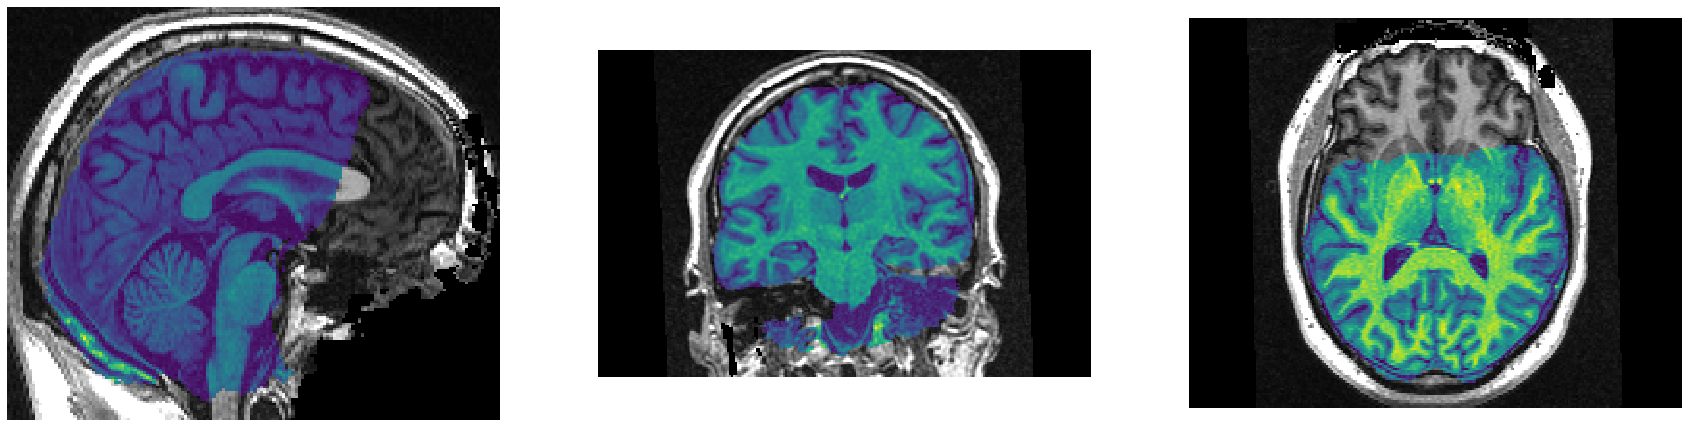

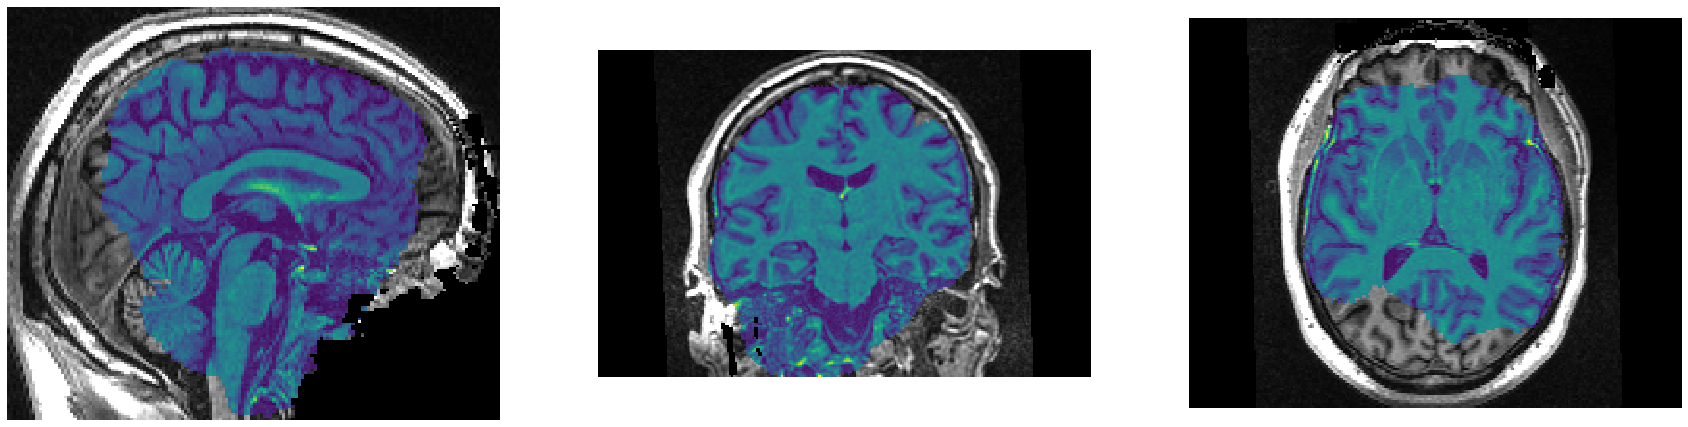

In [81]:
for biastype in ['nobias', 'weakbias', 'strongbias']:
    t1 = classdir / 'biascompare'/ 'ds000114'/ (biastype + '.anat') / 'T1_biascorr.nii.gz'
    mask = classdir / 'biascompare'/ 'ds000114'/ (biastype + '.anat') / 'T1_biascorr_brain.nii.gz'
    
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    orthoview(t1, axs, cmap = 'gray', vmax = 1000)
    orthoview(mask, axs, transparent = True)

    plt.show()

How do things look for our other data set?

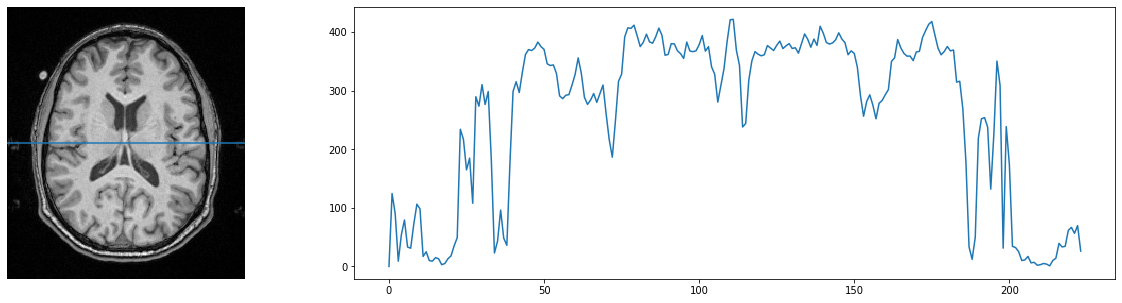

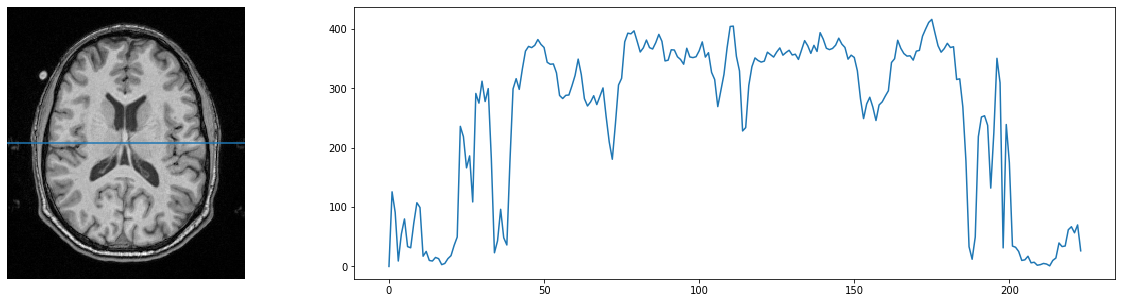

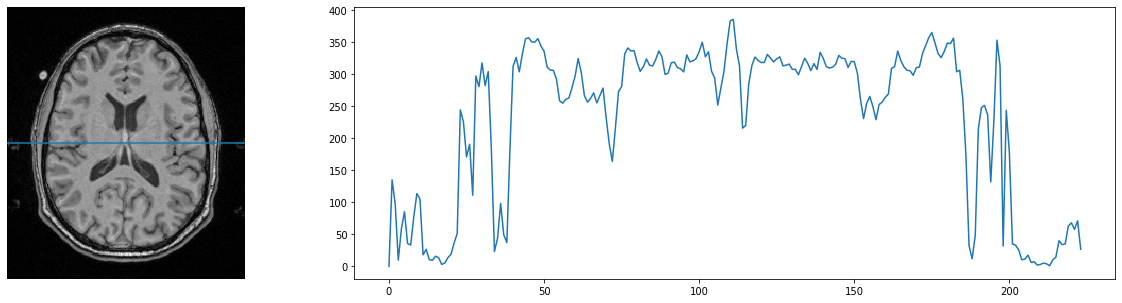

In [48]:
for biastype in ['nobias', 'weakbias', 'strongbias']:
    filename = classdir / 'biascompare'/ 'ds001728'/ (biastype + '.anat') / 'T1_biascorr.nii.gz'
    profile(filename, cmap = 'gray')

Again, a visible loss of contrast with strong bias correction. 

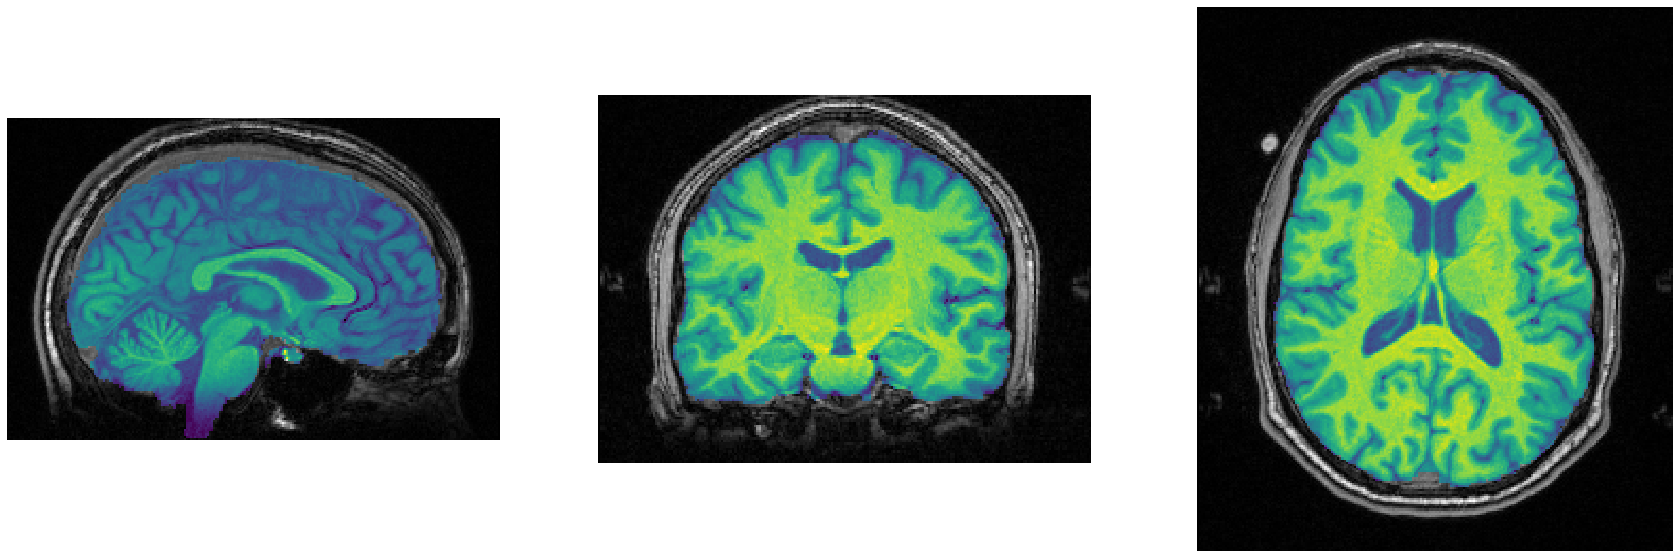

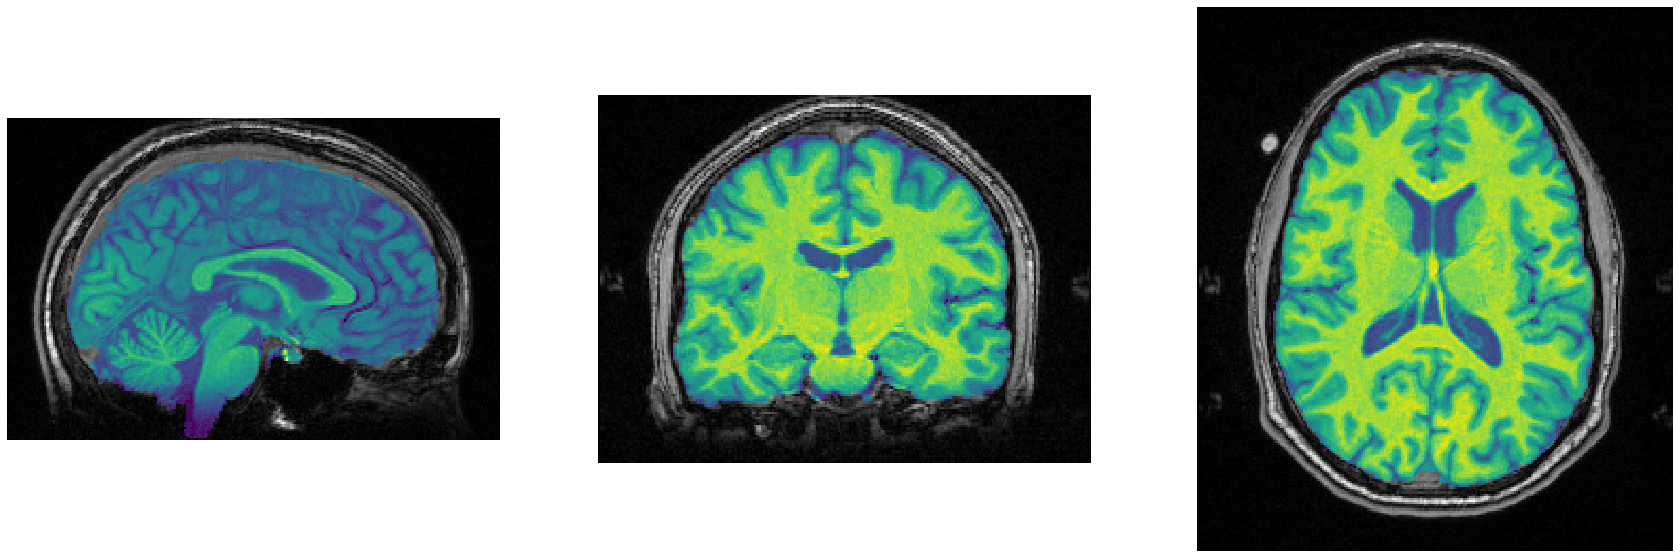

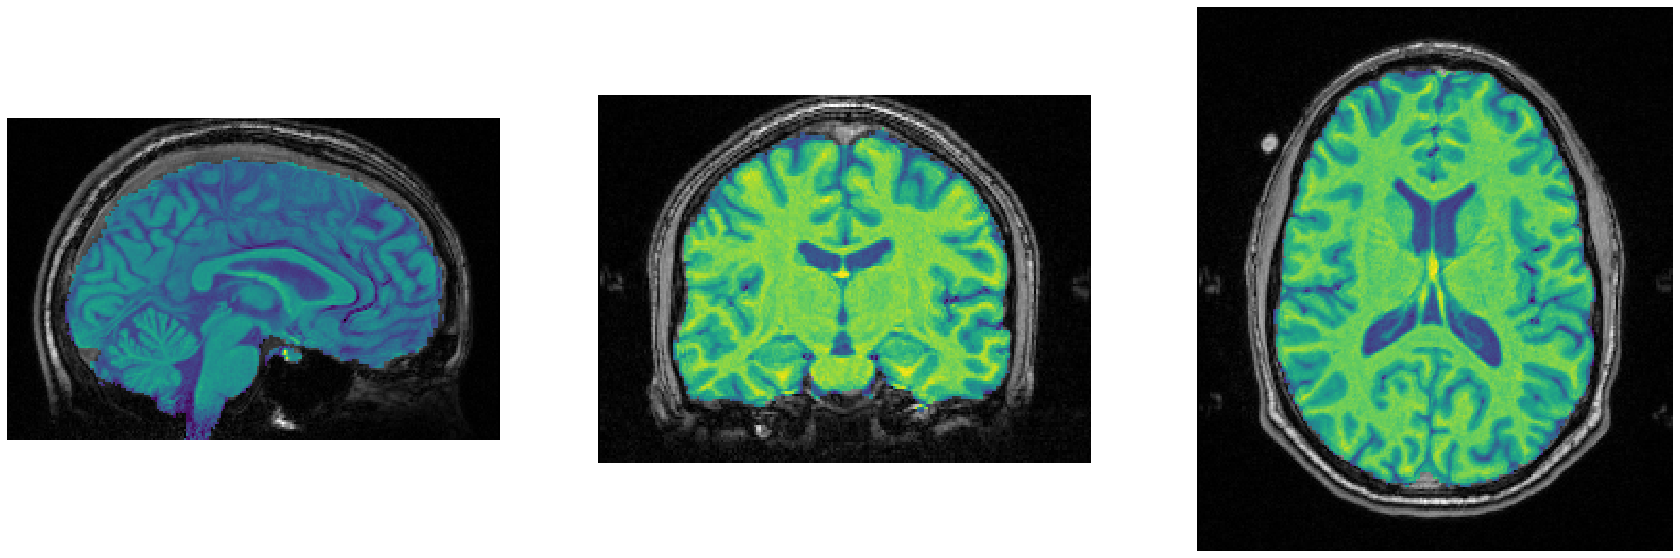

In [78]:
for biastype in ['nobias', 'weakbias', 'strongbias']:
    t1 = classdir / 'biascompare'/ 'ds001728'/ (biastype + '.anat') / 'T1_biascorr.nii.gz'
    mask = classdir / 'biascompare'/ 'ds001728'/ (biastype + '.anat') / 'T1_biascorr_brain.nii.gz'
    
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    orthoview(t1, axs, cmap = 'gray')
    orthoview(mask, axs, transparent = True)

    plt.show()

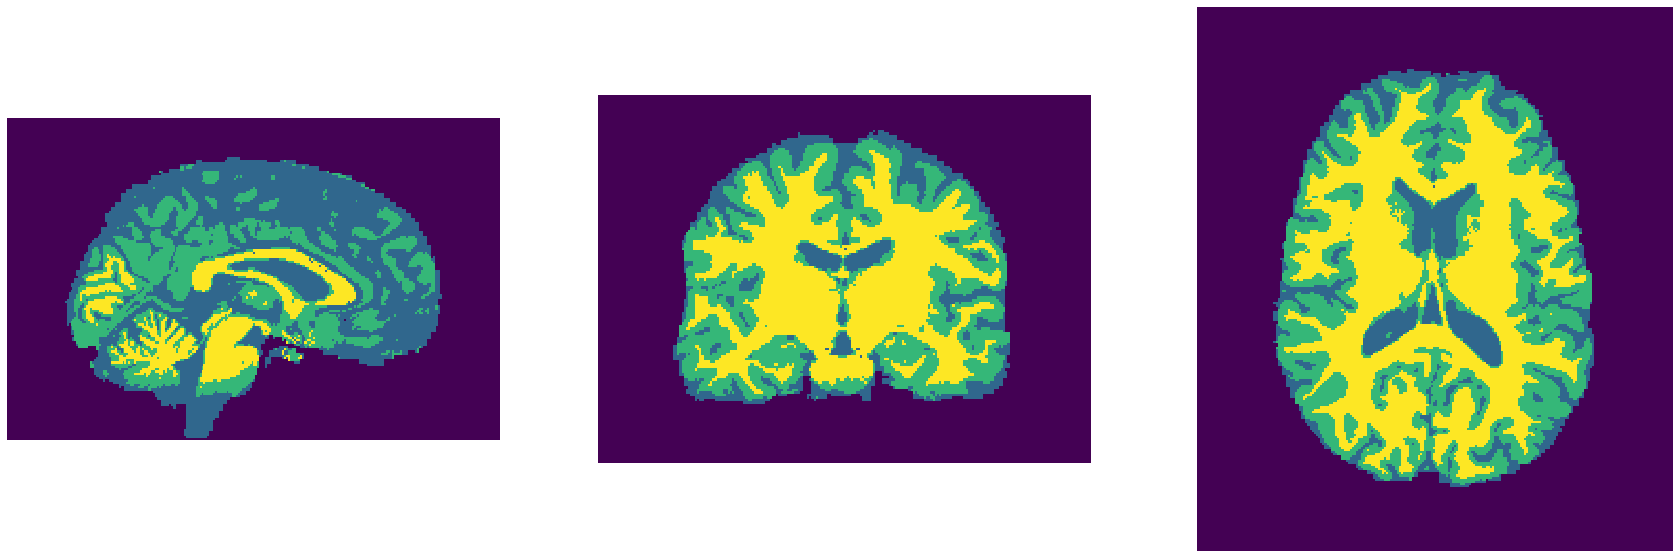

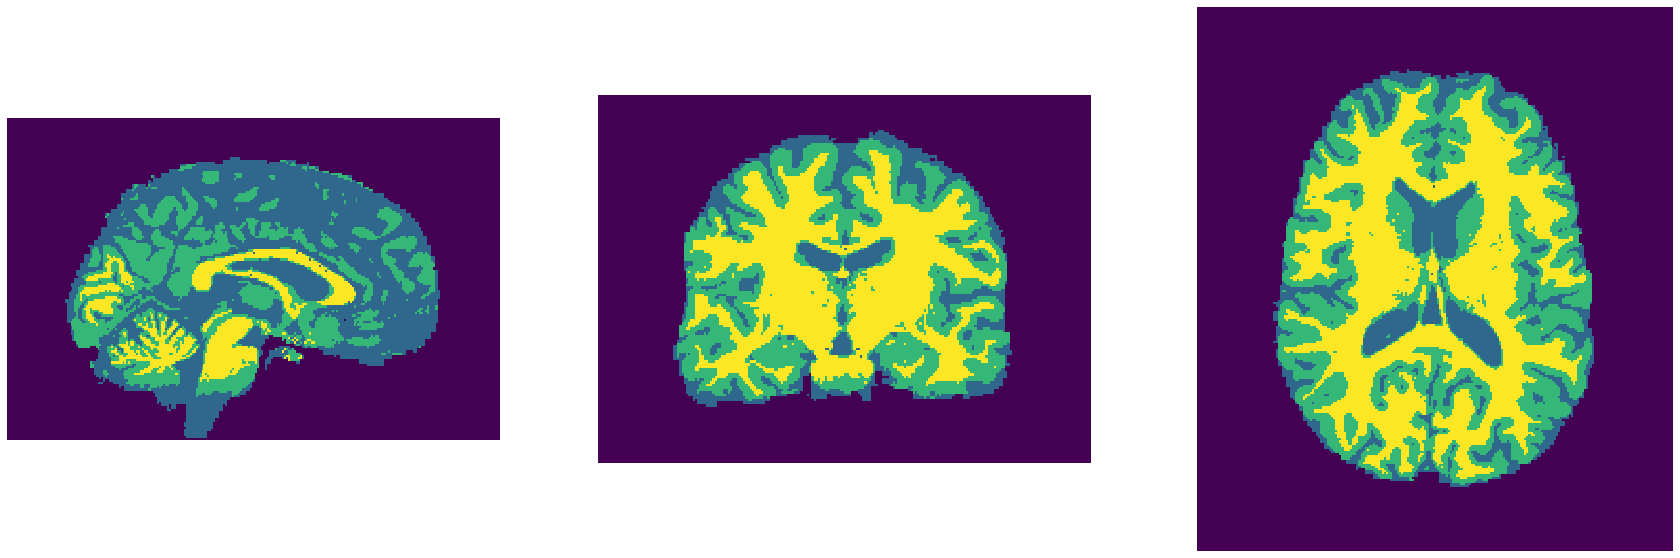

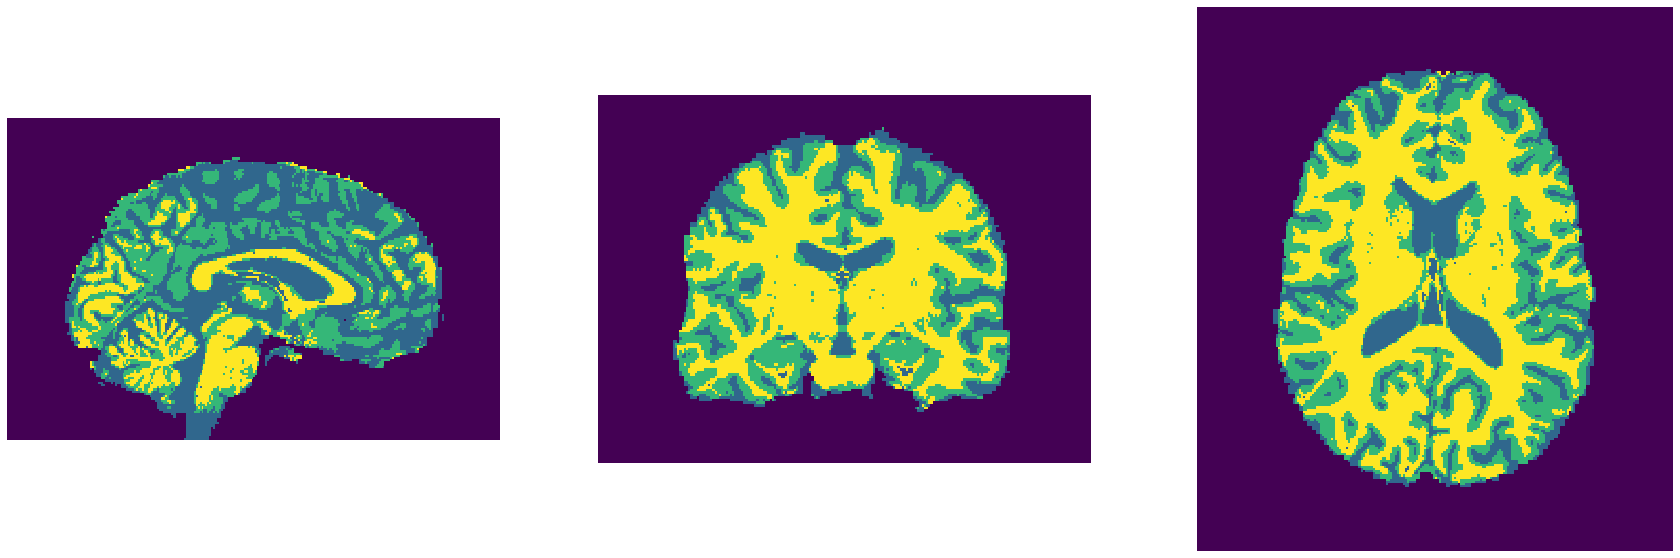

In [42]:
# 1st plot fast seg only
for biastype in ['nobias', 'weakbias', 'strongbias']:
    fast = classdir / 'biascompare'/ 'ds001728'/ (biastype + '.anat') / 'T1_fast_seg.nii.gz'
    subcort = classdir / 'biascompare'/ 'ds001728'/ (biastype + '.anat') / 'T1_subcort_seg.nii.gz'
    
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    orthoview(fast, axs)
    plt.show()

In [69]:
random_colormap = plt.cm.colors.ListedColormap ( np.random.rand ( 256,3))                               

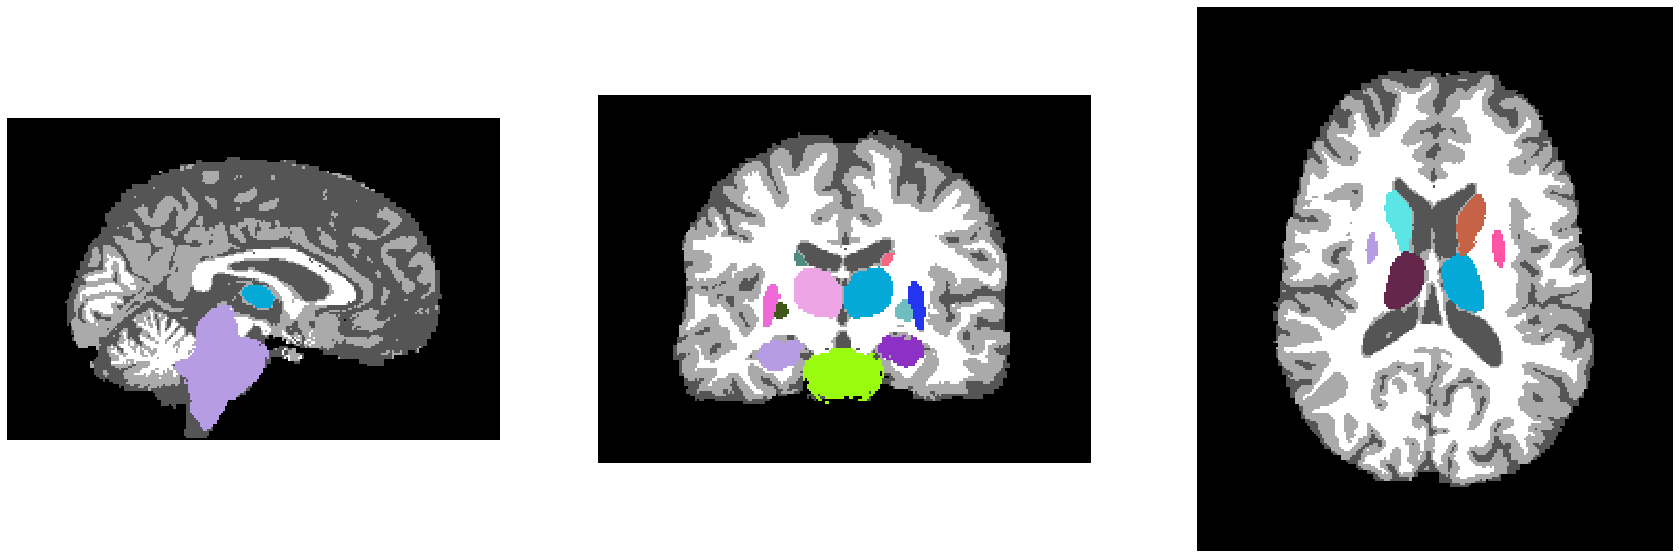

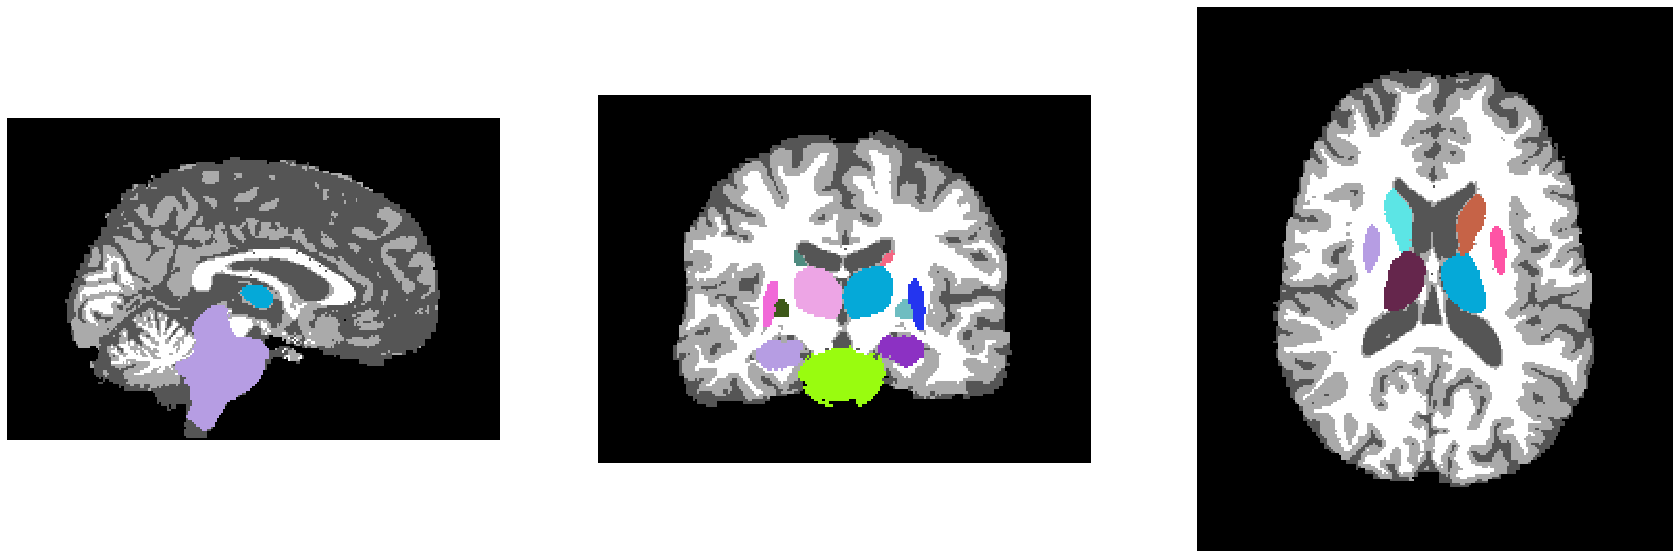

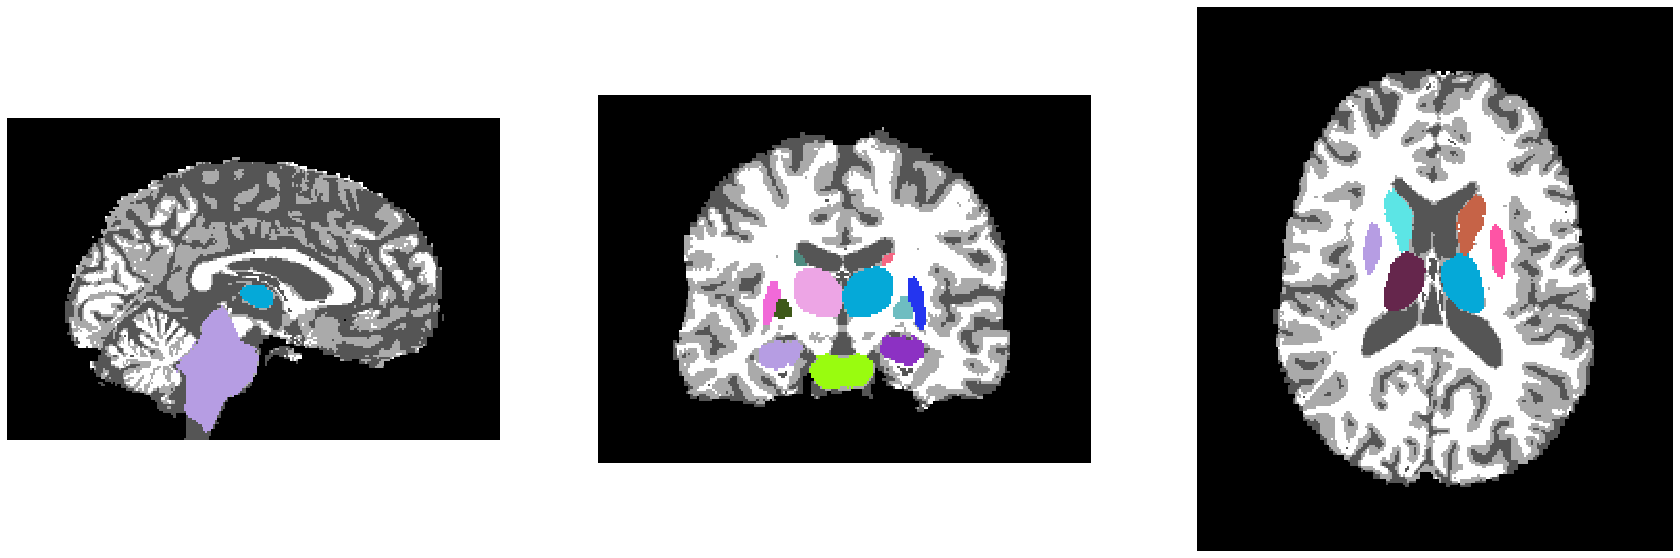

In [75]:
# overlay subcortical segmentation
for biastype in ['nobias', 'weakbias', 'strongbias']:
    fast = classdir / 'biascompare'/ 'ds001728'/ (biastype + '.anat') / 'T1_fast_seg.nii.gz'
    subcort = classdir / 'biascompare'/ 'ds001728'/ (biastype + '.anat') / 'T1_subcort_seg.nii.gz'
    
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    orthoview(fast, axs, cmap = 'gray')
    orthoview(subcort, axs, transparent = True, cmap = random_colormap)
    plt.show()

# the moral of the story
Don't assume pipeline defaults are going to be the best choice for your data set. Take the time to dig in and learn what they mean.